<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_icon_process.svg"
     alt="Cubes & Clouds Processing logo" width="00"
     style="width: 2500px; height:300px; float: center; margin-right: 10px;" />

# 3.3 Validation
In this exercise, we showcase the approach you can utilize to quickly validate the usefulness of your satellite-derived computation. In general, the integrity of the information derived from satellite observation is often showcased by stating its accuracy or some other metrics computed using in-situ measurements. Here, we compute a specified metric using the provided tools and resources on the cloud platform we are using.

The steps involved in this analysis:
- Generate Datacube time-series of snowmap,
- Load _in-situ_ datasets,
- Pre-process and filter _in-situ_ datasets to match area of interest, 
- Perform validation of snow-depth measurements

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

## Libraries

In [1]:
import json
from datetime import date
import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rio

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import geopandas as gpd
import leafmap.foliumap as leafmap
# from leafmap import leafmap
# import leafmap
import openeo

## Login
Connect to the copernicus dataspace ecosystem.

In [2]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [3]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Check if the login worked

In [4]:
conn.describe_account()

{'info': {'oidc_userinfo': {'email': 'rufaibalogun1@gmail.com',
   'email_verified': True,
   'family_name': 'Balogun',
   'given_name': 'Rufai Omowunmi',
   'name': 'Rufai Omowunmi Balogun',
   'preferred_username': 'rufaibalogun1@gmail.com',
   'sub': '06183cbc-84c8-4c6a-8a7d-cb18ba08cc8c'}},
 'name': 'Rufai Omowunmi Balogun',
 'user_id': '06183cbc-84c8-4c6a-8a7d-cb18ba08cc8c'}

## Region of Interest

In [5]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [6]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

## Generate Datacube of Snowmap

In [7]:
%run cubes_utilities.py

In [8]:
bbox = catchment_outline.bounds.iloc[0]
temporal_extent = ["2018-02-01", "2018-06-30"]
snow_map_cloud_free = calculate_sca(conn, bbox, temporal_extent)
snow_map_cloud_free

## Load snow-station in-situ data
Load the _in-situ_ datasets [snow cover in the European Alps](https://zenodo.org/record/5109574) with stations in our area of interest and subsequently catchment of interest.

In [9]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv")
# station_df.head()

In [10]:
# load additional metadata for acessing the station geometries
station_df_meta = pd.read_csv("data/meta_all.csv")
# station_df_meta.head()

## Pre-process and filter _in-situ_ datasets to match area of interest
- Temporally: Filter the in-situ datasets to match the snow-map time-series,
- Spatially: Filter the in-situ datasets into the catchment area of interest

Temporal Filter

In [11]:
start_date = "2018-02-01"
end_date = "2018-06-30"

snow_stations = station_temporal_filter(station_daily_df = station_df, 
                                        station_meta_df = station_df_meta,
                                        start_date = start_date,
                                        end_date = end_date)
# snow_stations.head()

Spatial filter

In [12]:
catchment_stations = station_spatial_filter(snow_stations, catchment_outline)
# catchment_stations.head()

Visualize location of snow stations

In [13]:
print("There are", len(np.unique(catchment_stations.Name)), "unique stations within our catchment area of interest")

There are 5 unique stations within our catchment area of interest


Binarize snow presence at station level

In [14]:
catchment_stations = catchment_stations.assign(snow_presence=catchment_stations.apply(binarize_snow, axis=1))
catchment_stations.head()

,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry,snow_presence
Date,,,,,,,,,,,,
2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268),0
2018-02-01,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,POINT (11.18361 46.70503),0
2018-02-01,IT_BZ,Plata_Osservatore,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285),1
2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,POINT (11.24713 46.80906),0
2018-02-01,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960),0


Save snow stations within catchment as GeoJSON

In [15]:
# save snow stations datasets as GeoJSON in the shared folder
with open("results/catchment_stations.geojson", "w") as file:
    file.write(catchment_stations.to_json())

### Aggregate snow value per station

Create buffer around snow stations and visualize

In [50]:
catchment_stations_gpd = gpd.read_file("results/catchment_stations.geojson")
# catchment_stations_gpd.plot()
mappy =leafmap.Map(center=center, zoom=16)
mappy.add_vector('data/catchment_outline.geojson', layer_name="catchment")
mappy.add_gdf(catchment_stations_gpd, layer_name="catchment_station")

catchment_stations_gpd["geometry"] = catchment_stations_gpd.geometry.buffer(0.00075)
mappy.add_gdf(catchment_stations_gpd, layer_name="catchment_station_buffer")
mappy

Convert unique geometries to Feature Collection

In [17]:
catchment_stations_fc = json.loads(
    catchment_stations_gpd.geometry.iloc[:5].to_json()
)
type(catchment_stations_fc)

dict

Aggregate spatial

In [18]:
snowmap_per_station= snow_map_cloud_free.aggregate_spatial(catchment_stations_fc, reducer="median")
snowmap_per_station

Save outputs from process graph

In [19]:
snowmap_cloudfree_json = snowmap_per_station.save_result(format="JSON")
job = snowmap_cloudfree_json.create_job(title="snow_map")
job.start_job()

In [39]:
job.status()

'finished'

In [40]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("results/snowmap/")

In [41]:
with open("results/snowmap/timeseries.json","r") as file:
    snow_time_series = json.load(file)

In [42]:
# snow_time_series

Extract snow values per station

In [51]:
catchment_stations_gpd

,id,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,snow_presence,geometry
0,2018-02-01,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261..."
1,2018-02-01,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,0,"POLYGON ((11.18436 46.70503, 11.18435 46.70496..."
2,2018-02-01,IT_BZ,Plata_Osservatore,2.0,55.0,2.0,55.0,55.0,11.176968,46.822847,1130.0,1,"POLYGON ((11.17772 46.82285, 11.17771 46.82277..."
3,2018-02-01,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,0,"POLYGON ((11.24788 46.80906, 11.24787 46.80899..."
4,2018-02-01,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,0,"POLYGON ((11.19158 46.68960, 11.19158 46.68952..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2018-06-30,IT_BZ,Plata_Osservatore,0.0,0.0,0.0,0.0,0.0,11.176968,46.822847,1130.0,0,"POLYGON ((11.17772 46.82285, 11.17771 46.82277..."
746,2018-06-30,IT_BZ,Scena_Osservatore,0.0,0.0,0.0,0.0,0.0,11.190831,46.689596,680.0,0,"POLYGON ((11.19158 46.68960, 11.19158 46.68952..."
747,2018-06-30,IT_BZ,Rifiano_Beobachter,0.0,0.0,0.0,0.0,0.0,11.183607,46.705034,500.0,0,"POLYGON ((11.18436 46.70503, 11.18435 46.70496..."
748,2018-06-30,IT_BZ,S_Leonardo_in_Passiria_Osservatore,0.0,NaN,0.0,NaN,NaN,11.247126,46.809062,644.0,0,"POLYGON ((11.24788 46.80906, 11.24787 46.80899..."


In [43]:
# extra snow values from time-series output
dates = [k.split("T")[0] for k in snow_time_series]
snow_val_smartino = [snow_time_series[k][0][0] for k in snow_time_series]
snow_val_rifiano = [snow_time_series[k][1][0] for k in snow_time_series]
snow_val_plata = [snow_time_series[k][2][0] for k in snow_time_series]
snow_val_sleonardo = [snow_time_series[k][3][0] for k in snow_time_series]
snow_val_scena = [snow_time_series[k][4][0] for k in snow_time_series]

# filter in-situ data to match dates in snow map output
catchment_stations_gpd_smartino = catchment_stations_gpd.query("Name == 'S_Martino_in_Passiria_Osservatore'")
catchment_stations_gpd_smartino = catchment_stations_gpd_smartino[
    catchment_stations_gpd_smartino.id.isin(dates)
]

catchment_stations_gpd_rifiano = catchment_stations_gpd.query("Name == 'Rifiano_Beobachter'")
catchment_stations_gpd_rifiano = catchment_stations_gpd_rifiano[
    catchment_stations_gpd_rifiano.id.isin(dates)
]

catchment_stations_gpd_plata = catchment_stations_gpd.query("Name == 'Plata_Osservatore'")
catchment_stations_gpd_plata = catchment_stations_gpd_plata[
    catchment_stations_gpd_plata.id.isin(dates)
]

catchment_stations_gpd_sleonardo = catchment_stations_gpd.query("Name == 'S_Leonardo_in_Passiria_Osservatore'")
catchment_stations_gpd_sleonardo = catchment_stations_gpd_sleonardo[
    catchment_stations_gpd_sleonardo.id.isin(dates)
]

catchment_stations_gpd_scena = catchment_stations_gpd.query("Name == 'Scena_Osservatore'")
catchment_stations_gpd_scena = catchment_stations_gpd_scena[
    catchment_stations_gpd_scena.id.isin(dates)
]

In [44]:
smartino_snow = assign_site_snow(catchment_stations_gpd_smartino, snow_val_smartino)
rifiano_snow = assign_site_snow(catchment_stations_gpd_rifiano, snow_val_rifiano)
plata_snow = assign_site_snow(catchment_stations_gpd_plata, snow_val_plata)
sleonardo_snow = assign_site_snow(catchment_stations_gpd_sleonardo, snow_val_sleonardo)
scena_snow = assign_site_snow(catchment_stations_gpd_scena, snow_val_scena)                                                                    

In [26]:
# sample of values in one 
smartino_snow.sample(5)

,Provider,Name,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,snow_presence,geometry,cube_snow
id,,,,,,,,,,,,,
2018-04-19,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261...",0.0
2018-02-26,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261...",0.0
2018-02-16,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261...",0.0
2018-02-28,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261...",0.0
2018-03-23,IT_BZ,S_Martino_in_Passiria_Osservatore,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,0,"POLYGON ((11.22866 46.78268, 11.22866 46.78261...",0.0


Display snow presence threshold in in-situ data

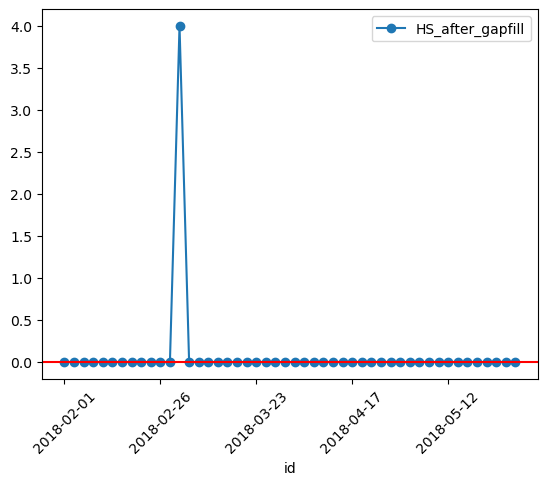

In [27]:
catchment_stations_gpd_rifiano.plot(x="id", y="HS_after_gapfill",rot=45,kind="line",marker='o')
plt.axhline(y = 0, color = "r", linestyle = "-")
plt.show()

## Confusion matrix

Saint Martino in Passiria Osservatore

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [29]:
def validation_metrics(df):
    acc = accuracy_score(df.snow_presence, df.cube_snow)
    cf = confusion_matrix(df.snow_presence, df.cube_snow)
    
    # cm_display = ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = [True, False])
    sns.heatmap(cf, annot=True)
    # cm_display.plot()
    plt.show()
    
    print (f"Accuracy is: {acc*100}%", "\nConfusion Matrix is:\n", cf)
    

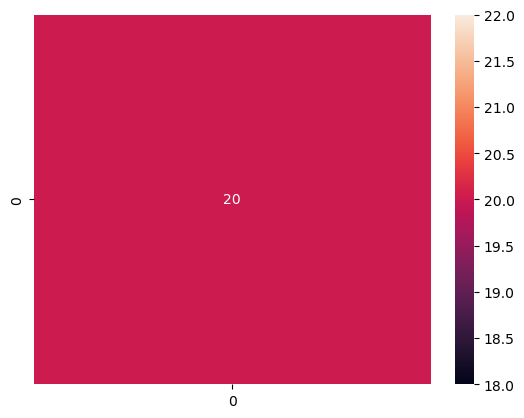

Accuracy is: 100.0% 
Confusion Matrix is:
 [[20]]


In [30]:
validation_metrics(smartino_snow)

Rifiano Beobachter

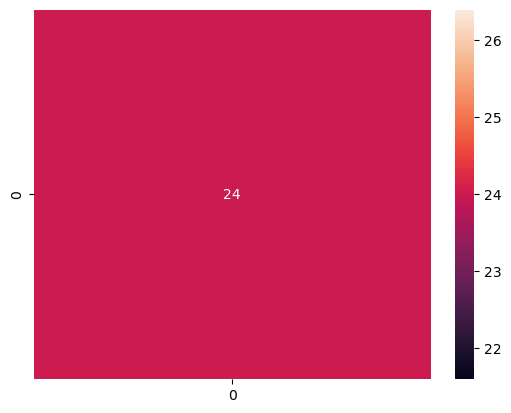

Accuracy is: 100.0% 
Confusion Matrix is:
 [[24]]


In [31]:
validation_metrics(rifiano_snow)

Plata Osservatore

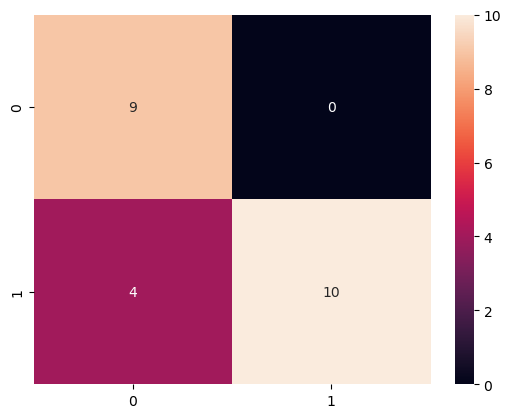

Accuracy is: 82.6086956521739% 
Confusion Matrix is:
 [[ 9  0]
 [ 4 10]]


In [32]:
validation_metrics(plata_snow) 

Saint Leonardo in Passiria Osservatore

In [52]:
# validation_metrics(sleonardo_snow)
# sleonardo_snow

Scena Osservatore

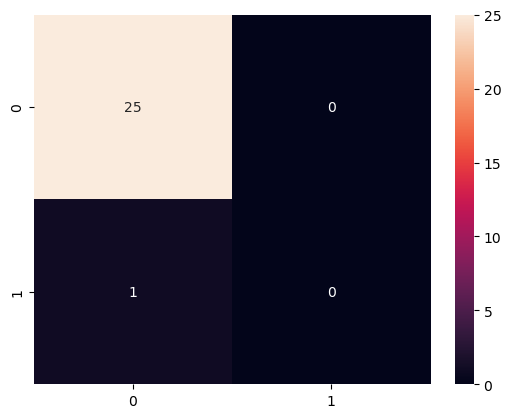

Accuracy is: 96.15384615384616% 
Confusion Matrix is:
 [[25  0]
 [ 1  0]]


In [34]:
validation_metrics(scena_snow)

## Compare to discharge data
In addition to computing metrics for validating the data, another approach is comparing the generated with another parameter with a known relationship. In this case, we compare the **snow cover area** time series with the **discharge** time-series at the main outlet of the catchment. 

Load the discharge data at Meran. The main outlet of the catchment

In [35]:
discharge_ds = pd.read_csv('data/ADO_DSC_ITH1_0025.csv', 
                           sep=',', index_col='Time', parse_dates=True)
discharge_ds.head()

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80


In [36]:
snow_perc_df = pd.read_csv("data/filtered_snow_perc.csv", 
                          sep=',', index_col='time', parse_dates=True)

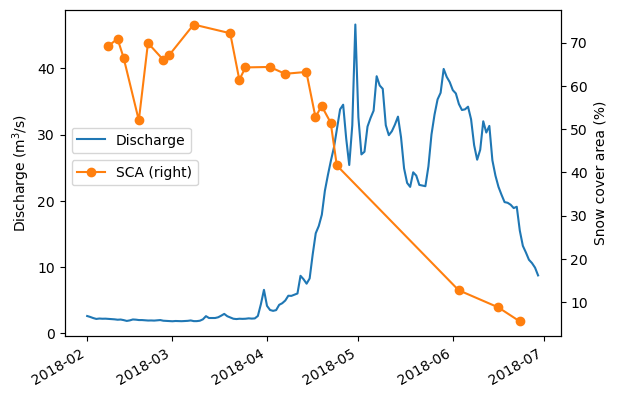

In [37]:
start_date = date(2018, 2, 1)
end_date = date(2018, 6, 30)
# filter discharge data to start and end dates
discharge_ds = discharge_ds.loc[start_date:end_date]

ax1 = discharge_ds.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)')
ax2 = snow_perc_df["perc_snow"].plot(marker='o', secondary_y=True, label='SCA', xlabel='', ylabel='Snow cover area (%)')
ax1.legend(loc='center left', bbox_to_anchor=(0, 0.6))
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.5))
plt.show()